# Library

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
import numpy as np
import tensorflow as tf

seed = 555

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Parameters

In [29]:
ticker = "AAPL"
lag = 10
start_date = "2018-01-01"
end_date = "2023-04-04"
train_test_ratio = 0.9
num_epochs = 200

# Functions

## Data

### Finance Data

In [4]:
def prep_finance(ticker, start_date="2018-01-01", end_date="2023-04-04"): # create_multi_df
    # Load data
    tickerData = yf.Ticker(ticker)
    tickerDF = tickerData.history(period="1d", start=start_date, end=end_date)

    # cut some variables
    tickerDF = tickerDF.drop("Dividends", axis=1)
    tickerDF = tickerDF.drop("Stock Splits", axis=1)

    # add control variables
    tickerDataDJI = yf.Ticker('^DJI')
    tickerDFDJI = tickerDataDJI.history(period='1d', start=start_date, end=end_date)
    # tickerDFDJI['DJI_Lag1'] = tickerDFDJI['Close'].shift(1)
    # tickerDF = pd.merge(tickerDF, tickerDFDJI['DJI_Lag1'], left_index=True, right_index=True)
    tickerDFDJI['DJI'] = tickerDFDJI['Close']
    tickerDF = pd.merge(tickerDF, tickerDFDJI['DJI'], left_index=True, right_index=True)

    # delete na rows
    tickerDF = tickerDF.dropna()
    
    return tickerDF

### Text Data

In [5]:
finbert_path = "/content/output_FinBert_final.xlsx"
textblob_path = "/content/output_TextBlob.xlsx"
vader_path = "/content/output_VADER.xlsx"
flair_path = "/content/Result_Flair_v1.xlsx"

In [8]:
finbert = pd.read_excel(finbert_path, index_col=0)
finbert = finbert.drop(["Neutral"], axis=1) # avoid multicollinearity
finbert = finbert.rename(columns={'Positive': 'finbert_pos', 'Negative': 'finbert_neg'})

textblob = pd.read_excel(textblob_path, index_col=0)

vader = pd.read_excel(vader_path, index_col=0)
vader = vader.drop(["vader_neu", "vader_pos", "vader_neg"], axis=1) # avoid multicollinearity

flair = pd.read_excel(flair_path, index_col=0)
flair = flair.reset_index()
flair = flair.rename(columns={"Date":"date", "Stock name":"stock_name", "Report type":"report_type"}) # fix typo
flair["flair_sentiment"] = flair.apply(lambda x: x["Sentiment score"] if x["Sentiment value"] == "POSITIVE" else 1-x["Sentiment score"], axis=1)
flair = flair.drop(["Sentiment score"], axis=1)

In [7]:
def prep_text(df, feature_lst, ticker):
    df_ticker = df[df["stock_name"]==ticker]
    df_ticker = df_ticker.groupby(["date", "report_type"], as_index=False).mean()

    df_ticker.set_index("date", inplace=True)

    df_ticker_8k = df_ticker[df_ticker["report_type"]=="8-K"]
    df_ticker_10k = df_ticker[df_ticker["report_type"]=="10-K"]
    df_ticker_10q = df_ticker[df_ticker["report_type"]=="10-Q"]
    df_ticker_10f = df_ticker[(df_ticker["report_type"]=="10-Q") | (df_ticker["report_type"]=="10-K")]

    name_dict_8k = {}
    name_dict_10k = {}
    name_dict_10q = {}
    name_dict_10f = {}
    for feature in feature_lst:
        name_dict_8k[feature] = feature+"_8k"
        name_dict_10k[feature] = feature+"_10k"
        name_dict_10q[feature] = feature+"_10q"
        name_dict_10f[feature] = feature+"_10f"

    df_ticker = pd.merge(df_ticker, df_ticker_8k[feature_lst].rename(columns=name_dict_8k), left_index=True, right_index=True, how='outer')
    df_ticker = pd.merge(df_ticker, df_ticker_10k[feature_lst].rename(columns=name_dict_10k), left_index=True, right_index=True, how='outer')
    df_ticker = pd.merge(df_ticker, df_ticker_10q[feature_lst].rename(columns=name_dict_10q), left_index=True, right_index=True, how='outer')
    df_ticker = pd.merge(df_ticker, df_ticker_10f[feature_lst].rename(columns=name_dict_10f), left_index=True, right_index=True, how='outer')
    df_ticker = df_ticker.drop(["report_type"]+feature_lst, axis=1)

    return df_ticker

In [9]:
def prep_all_text(ticker):
    finbert_ticker = prep_text(finbert, ["finbert_pos", "finbert_neg"], ticker)
    textblob_ticker = prep_text(textblob, ["tb_polarity", "tb_subjectivity"], ticker)
    vader_ticker = prep_text(vader, ["vader_compound"], ticker)
    flair_ticker = prep_text(flair, ["flair_sentiment"], ticker)

    text_ticker = pd.merge(finbert_ticker, textblob_ticker, left_index=True, right_index=True, how='outer')
    text_ticker = pd.merge(text_ticker, vader_ticker, left_index=True, right_index=True, how='outer')
    text_ticker = pd.merge(text_ticker, flair_ticker, left_index=True, right_index=True, how='outer')

    return text_ticker

In [30]:
feature_lst = ["finbert_pos", "finbert_neg", "tb_polarity", "tb_subjectivity", "vader_compound", "flair_sentiment"]

### Combine Data

In [50]:
def prep_all_feature(ticker, fill_method='ffill', n_days=10):
    fin_data = prep_finance(ticker)
    text_data = prep_all_text(ticker)
    fin_data.index = fin_data.index.strftime("%Y-%m-%d")
    text_data.index = text_data.index.strftime("%Y-%m-%d")
    res = pd.merge(fin_data, text_data, left_index=True, right_index=True, how="left")

    if fill_method == 'ffill':
        res.fillna(method='ffill', inplace=True)
        res = res.dropna()
    elif fill_method == 'limit':
        res.fillna(method='ffill', limit=n_days, inplace=True)
        res = res.fillna(0)

    return res

In [37]:
def filter_data(res, model_type='baseline'):
    col_baseline = ['Open', 'High', 'Low', 'Close', 'Volume', 'DJI']
    if model_type == 'baseline':
      return res.loc[:, col_baseline]
    else:
      col_target = col_baseline + [col for col in res if col.startswith('mask')] + [col for col in res if col.startswith(model_type)]
      return res.loc[:, col_target]

In [51]:
res = prep_all_feature(ticker, fill_method='limit')
res_filter = filter_data(res, model_type='vader')
res_filter

,Open,High,Low,Close,Volume,DJI,vader_compound_8k,vader_compound_10k,vader_compound_10q,vader_compound_10f
Date,,,,,,,,,,
2018-01-02,40.389599,40.897554,40.175970,40.888058,102223600,24824.009766,0.0,0.0,0.0,0.0
2018-01-03,40.952149,41.431622,40.816854,40.880939,118071600,24922.679688,0.0,0.0,0.0,0.0
2018-01-04,40.954522,41.175271,40.845338,41.070831,89738400,25075.130859,0.0,0.0,0.0,0.0
2018-01-05,41.168148,41.626256,41.075577,41.538433,94640000,25295.869141,0.0,0.0,0.0,0.0
2018-01-08,41.384151,41.683227,41.284456,41.384151,82271200,25283.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-03-28,157.970001,158.490005,155.979996,157.649994,45992200,32394.250000,0.0,0.0,0.0,0.0
2023-03-29,159.369995,161.050003,159.350006,160.770004,51305700,32717.599609,0.0,0.0,0.0,0.0
2023-03-30,161.529999,162.470001,161.270004,162.360001,49501700,32859.031250,0.0,0.0,0.0,0.0


## Model

In [17]:
def LSTM_scaled_multi_model(df, lag, train_test_ratio, epoch):
    # scale data
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    scaler_pred = MinMaxScaler()
    close_scaled = scaler_pred.fit_transform(df['Close'].values.reshape(-1, 1))
    
    # reshape inputs
    X, y = [], []
    df_len = df_scaled.shape[0]
    for i in range(lag, df_len):
        X.append(df_scaled.iloc[i-lag:i,:].transpose())
        y.append(df_scaled.iloc[i]["Close"])
    X = np.array(X)
    y = np.array(y)

    # split train and test
    cutoff = int(train_test_ratio * X.shape[0])
    X_train = X[:cutoff]
    X_test = X[cutoff:]
    y_train = y[:cutoff]
    y_test = y[cutoff:]

    # define model
    n_neurons = X_train.shape[1] * X_train.shape[2] # num_features x lag
    model = Sequential()
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")

    # fit model
    model.fit(X_train, y_train, epochs=epoch, verbose=0)

    # predict
    y_pred = model.predict(X_test, verbose=0)

    # unscale
    y_true = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_pred.inverse_transform(y_pred)

    return y_true, y_pred, cutoff

## Evaluation

In [18]:
def plot_pred(y_true, y_pred, df):
    # create two sample arrays
    x = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in data.index.tolist()]
    x = x[-len(y_true):]
    # x = [datetime.strptime(d, "%Y-%m-%d") for d in x]

    # create a new figure and axis
    fig, ax = plt.subplots()

    # plot the two arrays on the same axis
    ax.plot(x, y_true, label="true")
    ax.plot(x, y_pred, label="pred")

    # add legend and axis labels
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))

    # display the plot
    plt.show()

In [19]:
def RMSE(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return rmse

# Results

## Single Company

In [ ]:
prep_all_feature(ticker)

,Open,High,Low,Close,Volume,DJI,Positive_8k,Negative_8k,Positive_10k,Negative_10k,...,vader_neg_10q,vader_pos_10q,vader_compound_10q,vader_neg_10f,vader_pos_10f,vader_compound_10f,flair_sentiment_8k,flair_sentiment_10k,flair_sentiment_10q,flair_sentiment_10f
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-05,49.050051,49.071658,47.578309,48.399410,264654800,25461.699219,0.018920,0.038176,0.128327,0.401230,...,0.036778,0.076056,0.593611,0.072898,0.092959,0.353541,0.000742,0.135803,0.270224,0.135803
2018-11-06,48.478637,49.150885,48.423418,48.922802,127531600,25635.009766,0.018920,0.038176,0.128327,0.401230,...,0.036778,0.076056,0.593611,0.072898,0.092959,0.353541,0.000742,0.135803,0.270224,0.135803
2018-11-07,49.451008,50.432969,49.009246,50.406559,133697600,26180.300781,0.018920,0.038176,0.128327,0.401230,...,0.036778,0.076056,0.593611,0.072898,0.092959,0.353541,0.000742,0.135803,0.270224,0.135803
2018-11-08,50.589656,50.623386,49.811466,50.230679,101450400,26191.220703,0.018920,0.038176,0.128327,0.401230,...,0.036778,0.076056,0.593611,0.072898,0.092959,0.353541,0.000742,0.135803,0.270224,0.135803
2018-11-09,49.522358,49.633182,48.727301,49.262157,137463200,25989.300781,0.018920,0.038176,0.128327,0.401230,...,0.036778,0.076056,0.593611,0.072898,0.092959,0.353541,0.000742,0.135803,0.270224,0.135803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28,157.970001,158.490005,155.979996,157.649994,45992200,32394.250000,0.053306,0.153291,0.142870,0.460199,...,0.076889,0.053222,-0.136867,0.076889,0.053222,-0.136867,0.130900,0.132198,0.141019,0.141019
2023-03-29,159.369995,161.050003,159.350006,160.770004,51305700,32717.599609,0.053306,0.153291,0.142870,0.460199,...,0.076889,0.053222,-0.136867,0.076889,0.053222,-0.136867,0.130900,0.132198,0.141019,0.141019
2023-03-30,161.529999,162.470001,161.270004,162.360001,49501700,32859.031250,0.053306,0.153291,0.142870,0.460199,...,0.076889,0.053222,-0.136867,0.076889,0.053222,-0.136867,0.130900,0.132198,0.141019,0.141019


In [ ]:
data = prep_all_feature(ticker)
y_true, y_pred, cutoff = LSTM_scaled_multi_model(data.iloc[:,:6], lag, train_test_ratio, num_epochs)
print("baseline: " + str(RMSE(y_true, y_pred)))
for i in range(6,data.shape[1]):
    data_sub = data.iloc[:,[0,1,2,3,4,5]+[i]]
    y_true, y_pred, cutoff = LSTM_scaled_multi_model(data_sub, lag, train_test_ratio, num_epochs)
    print(data.columns[i] + ": " + str(RMSE(y_true, y_pred)))

baseline: 3.5332700088235414
Positive_8k: 3.552671515639554
Negative_8k: 3.752289218550434
Positive_10k: 3.787375681741021
Negative_10k: 3.868563058412674
Positive_10q: 3.8614492779302707
Negative_10q: 3.639798979187042
Positive_10f: 3.6517693315236173
Negative_10f: 3.9597648865448396
tb_polarity_8k: 3.8991695940873403
tb_subjectivity_8k: 4.361064546454466
tb_polarity_10k: 4.718667488481996
tb_subjectivity_10k: 3.5448742689220376
tb_polarity_10q: 3.6082138407054205
tb_subjectivity_10q: 4.001731536647248
tb_polarity_10f: 3.9760759481575674
tb_subjectivity_10f: 4.6224438895898174
vader_neg_8k: 3.5249199476387996
vader_pos_8k: 4.218508581562518
vader_compound_8k: 3.491640622613786
vader_neg_10k: 3.5587530316699985
vader_pos_10k: 3.811532711009828
vader_compound_10k: 4.92980185831822
vader_neg_10q: 3.684574635049125
vader_pos_10q: 4.443101578413046
vader_compound_10q: 3.794256758582856
vader_neg_10f: 4.281720928068815
vader_pos_10f: 3.902208460120221
vader_compound_10f: 6.181351375646682
f

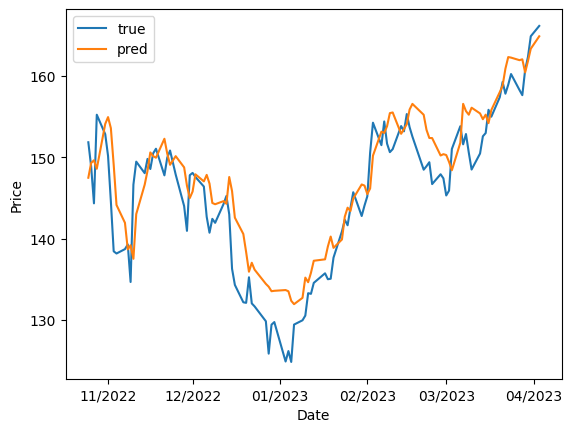

4.207677316915817


In [ ]:
data = prep_all_feature(ticker)
y_true, y_pred, cutoff = LSTM_scaled_multi_model(data, lag, train_test_ratio, num_epochs)
plot_pred(y_true, y_pred, data)
print(RMSE(y_true, y_pred))

## All Company

In [20]:
ticker_lst = ["AAPL", "MSFT", "V", "UNH", "JPM", "JNJ", "WMT", "PG", "CVX", "HD"]
lag = 10
start_date = "2018-01-01"
end_date = "2023-04-04"
train_test_ratio = 0.9
num_epochs = 200

In [52]:
def summary(ticker_lst, fill_method='limit'):
    df_res = pd.DataFrame(columns=['stock_name', 'rmse_baseline', 'rmse_vader', 'rmse_tb', 'rmse_finbert', 'rmse_flair'])
    for i, ticker in enumerate(ticker_lst):
        print(ticker)
        data = prep_all_feature(ticker, fill_method=fill_method)
        list_model_type = ['baseline', 'vader', 'tb', 'finbert', 'flair']
        list_rmse = list()
        for mdl in list_model_type:
            data_sub = filter_data(data, model_type=mdl)
            y_true, y_pred, cutoff = LSTM_scaled_multi_model(data_sub, lag, train_test_ratio, num_epochs)
            temp_rmse = RMSE(y_true, y_pred)
            list_rmse.append(temp_rmse)
            print(mdl + ": " + str(temp_rmse))
        
        temp = [ticker] + list_rmse
        df_res.loc[i, :] = temp

    # res = {'Company': ticker_lst, 'RMSE': rmse_lst}
    # res = pd.DataFrame(res)

    return df_res



In [23]:
res_ffill = summary(ticker_lst)
res_ffill.to_excel('result_ffill.xlsx')
res_ffill

AAPL
baseline: 3.6839900303852593
vader: 3.7332893651572547
tb: 4.052817470566619
finbert: 6.684268804831123
flair: 3.5980082404120908
MSFT
baseline: 6.464361626553213
vader: 5.670599882463677
tb: 5.946861869241994
finbert: 6.1685042540188135
flair: 5.661808023060133
V
baseline: 3.3064735339425995
vader: 3.633760418696663
tb: 3.2906158552638316
finbert: 3.7528774155393902
flair: 3.374071135830145
UNH
baseline: 10.51617419225612
vader: 11.97064628939418
tb: 11.071792288967396
finbert: 10.412553462816582
flair: 9.810471640162346
JPM
baseline: 2.256265186209203
vader: 2.117316385624806
tb: 2.4898868386657353
finbert: 2.416275302519233
flair: 2.7508987939690366
JNJ
baseline: 1.9692806596699304
vader: 2.2528034992774817
tb: 2.3426704758091024
finbert: 2.0683000968739114
flair: 2.503873491149025
WMT
baseline: 1.8130385139685297
vader: 1.7422923179749084
tb: 1.9157005862447352
finbert: 1.750091750985681
flair: 1.7339450648322963
PG
baseline: 1.9653002911538426
vader: 2.4808356961059976
tb: 3.

,stock_name,rmse_baseline,rmse_vader,rmse_tb,rmse_finbert,rmse_flair
0,AAPL,3.68399,3.733289,4.052817,6.684269,3.598008
1,MSFT,6.464362,5.6706,5.946862,6.168504,5.661808
2,V,3.306474,3.63376,3.290616,3.752877,3.374071
3,UNH,10.516174,11.970646,11.071792,10.412553,9.810472
4,JPM,2.256265,2.117316,2.489887,2.416275,2.750899
5,JNJ,1.969281,2.252803,2.34267,2.0683,2.503873
6,WMT,1.813039,1.742292,1.915701,1.750092,1.733945
7,PG,1.9653,2.480836,3.697086,2.683952,2.104775
8,CVX,3.746229,4.997373,4.024217,5.693433,4.917928
9,HD,6.622617,6.327916,6.702016,6.830253,6.393852


In [53]:
res_ffill = summary(ticker_lst, fill_method='limit')
res_ffill.to_excel('result_limit_nomask.xlsx')
res_ffill

AAPL
baseline: 3.4435379858727933
vader: 3.704302252539578
tb: 3.9097327402760285
finbert: 4.134297237480347
flair: 3.855709311527788
MSFT
baseline: 9.39264858229026
vader: 9.59352077066225
tb: 9.805937989362596
finbert: 7.995940967094425
flair: 8.900133835754916
V
baseline: 3.2810203326037697
vader: 3.690656916207112
tb: 3.486835269558304
finbert: 4.1509210281306945
flair: 3.5434600394787754
UNH
baseline: 8.581780354263746
vader: 9.048344358030006
tb: 12.237527666147278
finbert: 11.041897373555377
flair: 9.366550922345976
JPM
baseline: 2.432887788082993
vader: 2.4889346922422733
tb: 2.4927862649926444
finbert: 3.029063135962918
flair: 2.453455768952415
JNJ
baseline: 1.7647158947584713
vader: 2.101740200273603
tb: 2.067489809072219
finbert: 1.9443999325075427
flair: 2.003336880768381
WMT
baseline: 2.132603702698558
vader: 2.4696532989387903
tb: 2.2833313595995404
finbert: 2.808194999676575
flair: 3.1271677612893
PG
baseline: 2.618579206768066
vader: 3.6244053923010466
tb: 3.67420891962

,stock_name,rmse_baseline,rmse_vader,rmse_tb,rmse_finbert,rmse_flair
0,AAPL,3.443538,3.704302,3.909733,4.134297,3.855709
1,MSFT,9.392649,9.593521,9.805938,7.995941,8.900134
2,V,3.28102,3.690657,3.486835,4.150921,3.54346
3,UNH,8.58178,9.048344,12.237528,11.041897,9.366551
4,JPM,2.432888,2.488935,2.492786,3.029063,2.453456
5,JNJ,1.764716,2.10174,2.06749,1.9444,2.003337
6,WMT,2.132604,2.469653,2.283331,2.808195,3.127168
7,PG,2.618579,3.624405,3.674209,3.69414,3.237041
8,CVX,5.785853,5.743853,7.514261,7.946413,6.549996
9,HD,6.137631,6.50581,6.519096,6.000104,6.17905
